# Carregar as bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from datetime import datetime
from torchvision import datasets, models, transforms
from torchsummary import summary


## Treinamento a partir de uma base propria de imagens

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-10-06 13:10:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   115MB/s    in 0.6s    

2022-10-06 13:10:03 (115 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
%ls /tmp/cats_and_dogs_filtered


train/  validation/  vectorize.py


In [ ]:
!mv /tmp/cats_and_dogs_filtered/validation /tmp/cats_and_dogs_filtered/val

In [ ]:
%ls /tmp/cats_and_dogs_filtered

train/  val/  vectorize.py


## OBS: não executar. Perrmite carregar uma base de imagens. 

In [ ]:
transform = transforms.Compose([transforms.Resize(112),
                                transforms.CenterCrop(112),
                                transforms.ToTensor()])

mydataset_train = datasets.ImageFolder(
    root = '/tmp/cats_and_dogs_filtered/train',
    transform=transform,
 )
mydataset_test = datasets.ImageFolder(
    root = '/tmp/cats_and_dogs_filtered/val',
    transform=transform,
 )

#Data Loading
batch_size = 128
trainloader = torch.utils.data.DataLoader(mydataset_train, 
                                          batch_size=batch_size,
                                          shuffle = True)
testloader = torch.utils.data.DataLoader(mydataset_test, 
                                         batch_size=batch_size,
                                         shuffle = False)

batch de dados: torch.Size([128, 3, 112, 112])
batch de etiquetas: torch.Size([128])


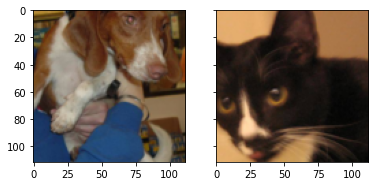

In [ ]:
# verificação do funcionamento do dataloader
for x, y in trainloader:
    print(f'batch de dados: {x.shape}')
    print(f'batch de etiquetas: {y.shape}')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(np.transpose(x[0].numpy(), (1,2,0)), cmap = 'gray')
    ax2.imshow(np.transpose(x[1].numpy(), (1,2,0)), cmap = 'gray')
#    ax1.imshow(x[0].numpy()[-1,:,:], cmap = 'gray')
#    ax2.imshow(x[1].numpy()[-1,:,:], cmap = 'gray')
    break

# Modelo de treinamento de uma CNN extraído de [link text](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

## Definição dos parâmetros iniciais

<ul>
    <li>data_dir: endereço onde está a base de imagens</li>
    <li>model_nome: mome do modelo</li>
    <li>num_classes: número de classes na base de imagens</li>
    <li>batch_size: número de amostras por batch</li>
    <li>feature_extract: se a rede funcionará como extrator de características ou se serão treinadas todas as capas</li>
</ul>

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "./data/hymenoptera_data"
data_dir = '/tmp/cats_and_dogs_filtered'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

## Função treinar uma rede
<ul>
    <li>model: modelo de rede</li>
    <li>dataLoader: dataloader responsável de selecionar as imagens para cada batch</li>
    <li>criterion: função Loss</li>
    <li>optimizer: função de otimização</li>
    <li>num_epocas: núnero de ciclos de treinamento</li>
</ul>

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Congela ou descongela as capas da rede, por *default* são carregadas descongeladas, ou seja, permite que todos os pesos da rede sejam atualizados durante o treino.

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### Carrega a rede selecionado, indicando se os pesos serão congelados ou não

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define as funções de transformação das imagens, carrega as imagens a partir de pastas, e creação de dataloaders
<ul>
<li>transforms: são definidas as diferentes funções de transformação (geométricas, normalização) e conversão a tensores</li>

<li>ImageFolder: permite carregar as imagens a partir de uma pasta em disco (root)</li>

<li>dataloader: selecionas as imagens para cada batch. Além disso, carrega as imagens dos batch somente quando utilizadas</li>
</ul>


```
root
|
-- train
|     |--classe 1
|     |     img1.png
|     |     img2.png
...
|     |--classe n
|     |     img1.png
|     |     img2.png
-- val
|     |--classe 1
|     |     img1.png
|     |     img2.png
...
|     |--classe n
|     |     img1.png
|     |     img2.png
```

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


### O modelo de rede carregado é enviado à GPU se disponível e mostra os parâmetros que serão atualizados durante o treino, e definição do otimizador usado para convergir uma determinada função de perda (Loss)

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


### Definição da função Loss e chamada à função de treino

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.3285 Acc: 0.8415
val Loss: 0.0542 Acc: 0.9840

Epoch 1/14
----------
train Loss: 0.3261 Acc: 0.8585
val Loss: 0.0541 Acc: 0.9820

Epoch 2/14
----------
train Loss: 0.3298 Acc: 0.8680
val Loss: 0.0471 Acc: 0.9850

Epoch 3/14
----------
train Loss: 0.2732 Acc: 0.8835
val Loss: 0.0476 Acc: 0.9840

Epoch 4/14
----------
train Loss: 0.2921 Acc: 0.8705
val Loss: 0.0494 Acc: 0.9830

Epoch 5/14
----------
train Loss: 0.2564 Acc: 0.8900
val Loss: 0.0465 Acc: 0.9820

Epoch 6/14
----------
train Loss: 0.2776 Acc: 0.8865
val Loss: 0.0408 Acc: 0.9860

Epoch 7/14
----------
train Loss: 0.2673 Acc: 0.8820
val Loss: 0.0451 Acc: 0.9780

Epoch 8/14
----------
train Loss: 0.3113 Acc: 0.8790
val Loss: 0.0569 Acc: 0.9800

Epoch 9/14
----------
train Loss: 0.2681 Acc: 0.8935
val Loss: 0.0471 Acc: 0.9840

Epoch 10/14
----------
train Loss: 0.2843 Acc: 0.8920
val Loss: 0.0712 Acc: 0.9690

Epoch 11/14
----------
train Loss: 0.2790 Acc: 0.8895
val Loss: 0.0625 Acc: 0.9740

Ep

### Treinamento total da rede (*from scratch*)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.7272 Acc: 0.5340
val Loss: 0.7331 Acc: 0.5070

Epoch 1/14
----------
train Loss: 0.7353 Acc: 0.5580
val Loss: 0.7856 Acc: 0.5120

Epoch 2/14
----------
train Loss: 0.7337 Acc: 0.5745
val Loss: 0.6753 Acc: 0.5640

Epoch 3/14
----------
train Loss: 0.7022 Acc: 0.5775
val Loss: 0.7344 Acc: 0.5460

Epoch 4/14
----------
train Loss: 0.6949 Acc: 0.5980
val Loss: 0.5994 Acc: 0.6990

Epoch 5/14
----------
train Loss: 0.6756 Acc: 0.6200
val Loss: 0.6306 Acc: 0.6520

Epoch 6/14
----------
train Loss: 0.6803 Acc: 0.6065
val Loss: 0.6366 Acc: 0.6600

Epoch 7/14
----------
train Loss: 0.6594 Acc: 0.6200
val Loss: 0.6730 Acc: 0.5970

Epoch 8/14
----------
train Loss: 0.6601 Acc: 0.6325
val Loss: 0.6186 Acc: 0.6470

Epoch 9/14
----------
train Loss: 0.6549 Acc: 0.6200
val Loss: 0.6688 Acc: 0.6290

Epoch 10/14
----------
train Loss: 0.6454 Acc: 0.6385
val Loss: 0.6397 Acc: 0.6590

Epoch 11/14
----------
train Loss: 0.6452 Acc: 0.6565
val Loss: 0.6043 Acc: 0.6770

Epoch 12/14
----------
t

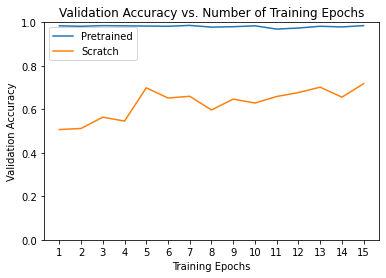

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [ ]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.backend_feat = [16, 16, 'M', 32, 32, 'M', 64, 64, 64, 'M', 128, 128, 128, 'M']
        self.conv_layers = make_layers(self.backend_feat, batch_norm=True)


        self.dense_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*7*7, 4096),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(4096, 512),
            nn.ReLU(),  

            nn.Linear(512, K)
        )

    def weight_init(self):
        for layer in self.conv_layers:
            if type(layer) == nn.Conv2d:
                nn.init.xavier_normal_(layer.weight)
        for layer in self.dense_layers:
            if type(layer) == nn.Linear:
                nn.init.xavier_normal_(layer.weight)

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1) # nn.Flatten()
        out = self.dense_layers(out)
        return out

In [ ]:
!nvidia-smi

Thu Oct  6 02:26:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    35W /  70W |  13696MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
K = 2
model_animal = CNN(K)
#summary(model_animal, (3,56, 56))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_animal.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(32, 64, ke

In [ ]:
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
#optimizer = torch.optim.Adagrad( model_animal.parameters() )
optimizer = torch.optim.SGD(model_animal.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

In [ ]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
 
            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

In [ ]:
model_animal.apply(weight_reset)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(32, 64, ke

In [ ]:
train_losses, test_losses = fit(model_animal, criterion, optimizer, trainloader, testloader, epochs = 20)

Epoch 1/20 Train Loss: 0.6511 Test Loss: 0.6387531459331512 Duracao: 0:00:12.954190
Epoch 2/20 Train Loss: 0.6408 Test Loss: 0.6224865019321442 Duracao: 0:00:12.274202
Epoch 3/20 Train Loss: 0.6268 Test Loss: 0.6105988100171089 Duracao: 0:00:12.347254
Epoch 4/20 Train Loss: 0.6067 Test Loss: 0.5952856615185738 Duracao: 0:00:12.311847
Epoch 5/20 Train Loss: 0.6003 Test Loss: 0.5849200002849102 Duracao: 0:00:12.400546
Epoch 6/20 Train Loss: 0.5697 Test Loss: 0.5672885999083519 Duracao: 0:00:13.296627
Epoch 7/20 Train Loss: 0.5567 Test Loss: 0.6765956152230501 Duracao: 0:00:12.831363
Epoch 8/20 Train Loss: 0.5323 Test Loss: 0.5731780715286732 Duracao: 0:00:12.203107
Epoch 9/20 Train Loss: 0.4990 Test Loss: 0.5492596849799156 Duracao: 0:00:12.174055
Epoch 10/20 Train Loss: 0.4839 Test Loss: 0.5451564937829971 Duracao: 0:00:12.304170
Epoch 11/20 Train Loss: 0.4638 Test Loss: 0.5527735203504562 Duracao: 0:00:12.120694
Epoch 12/20 Train Loss: 0.4435 Test Loss: 0.573270883411169 Duracao: 0:00:

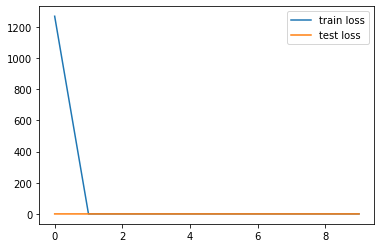

In [ ]:
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [ ]:
def predict_module(model, data_loader):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in data_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu().data.numpy())
        true_labels = np.append(true_labels, targets.cpu().data.numpy())

    return predicted, true_labels

In [ ]:
predicted, true_labels = predict_module(model_animal, testloader)

In [ ]:
def matriz_confusao(true_labels, predicted):
    m = metrics.confusion_matrix(true_labels, predicted) 
    tot = np.sum(m, axis=1, keepdims=True) 

    m_porc = m/tot
    m_porc_str = np.array2string(m_porc, formatter={'float_kind':lambda x: "%.2f" % x})
    print( m_porc_str )

    np.set_printoptions(precision=2, suppress = True)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m, display_labels=[0,1,2,3,4,5,6,7,8,9])
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)
    plt.show()

[[0.87 0.13]
 [0.37 0.63]]


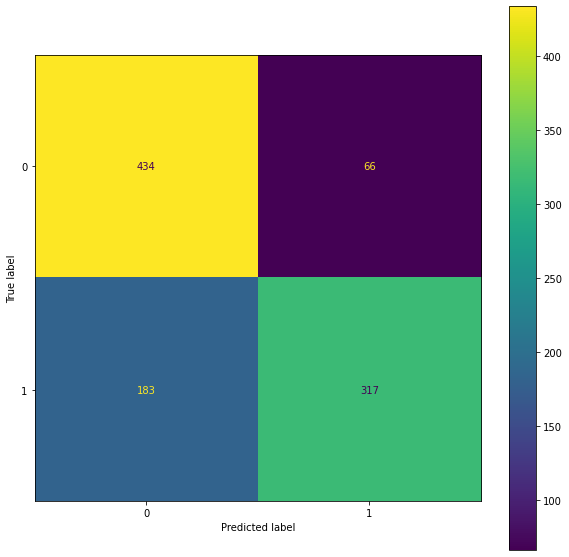

In [ ]:
matriz_confusao(true_labels, predicted) 